In [1]:
import os
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import requests

/Users/sanjanapaul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


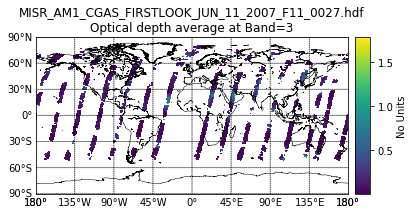

In [2]:
#should adapt so that you can download the file from the link like i have it for opendap 
#access from this link
#MI3DAEF file type - but it only goes up to 2017
#https://search.earthdata.nasa.gov/search/granules?p=C156141681-LARC&q=MISR%20aerosols&m=-26.578125!6.890625!3!1!0!0%2C2&fdc=Atmospheric%20Science%20Data%20Center%20(ASDC)&fl=3%20-%20Gridded%20Observations&tl=1559406523!4!!&fst0=Atmosphere&fsm0=Atmospheric%20Radiation&fst1=Atmosphere&fsm1=Aerosols
hdffile='MISR_AM1_CGAS_FIRSTLOOK_JUN_11_2007_F11_0027.hdf'

from pyhdf.SD import SD, SDC
hdf = SD(hdffile, SDC.READ)

DATAFIELD_NAME = 'Optical depth average'

    # Read dataset.
data3D = hdf.select(DATAFIELD_NAME)
data = data3D[:,:,3].astype(np.double)

    # Read file attribute.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]

# Read dataset attribute.
attrs = data3D.attributes(full=1)
fva=attrs["_FillValue"]
_FillValue = fva[0]

# Apply the fill value.
data[data == _FillValue] = np.nan
datam = np.ma.masked_array(data, mask=np.isnan(data))


    # Construct the grid.  The needed information is in a global attribute
    # called 'StructMetadata.0'.  Use regular expressions to tease out the
    # extents of the grid.
    #so the below code is equivalent to gd.readfield from MATLAB
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = ul_regex.search(gridmeta)
x0 = np.float(match.group('upper_left_x')) / 1000000.0
y0 = np.float(match.group('upper_left_y')) / 1000000.0

lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float(match.group('lower_right_x')) / 1000000.0
y1 = np.float(match.group('lower_right_y')) / 1000000.0

data = data.T
nx, ny = data.shape
x = np.linspace(x0, x1, nx)
y = np.linspace(y0, y1, ny)
lon, lat = np.meshgrid(x, y)

m = Basemap(projection='cyl', resolution='l',
        llcrnrlat=-90, urcrnrlat = 90,
        llcrnrlon=-180, urcrnrlon = 180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
m.pcolormesh(lon, lat, datam, latlon=True)

cb = m.colorbar()
# Albedo doesn't have a unit according to the specification [1].
cb.set_label('No Units')

basename = os.path.basename(hdffile)
plt.title('{0}\n{1} at Band=3'.format(basename, DATAFIELD_NAME))
fig = plt.gcf()
plt.show()